In [216]:
import numpy as np
import pandas as pd
import seaborn as sns # for visualiation
import matplotlib.pyplot as plt
import data_prep as dp


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge


# Load data
features_train = pd.read_csv('./data/dengue_features_train.csv')
labels_train = pd.read_csv('./data/dengue_labels_train.csv')
features_test = pd.read_csv('./data/dengue_features_test.csv')

# San Juan
data_sj = dp.features_train(features_train, labels_train, 'sj')
data_sj_n = dp.normalize(data_sj)
data_test_sj = dp.features_test(features_test, features_train, 'sj')
data_test_sj_n = dp.normalize(data_test_sj)

# Iquitos
data_iq = dp.features_train(features_train, labels_train, 'iq')
data_iq_n = dp.normalize(data_iq)
data_test_iq = dp.features_test(features_test, features_train, 'iq')
data_test_iq_n = dp.normalize(data_test_iq)

# San Juan

## K Nearest Neighbor

In [ ]:
train_features_sj, test_features_sj, train_outcomes_sj, test_outcomes_sj = train_test_split(
    data_sj_n,
    data_sj['total_cases'],
    test_size = 0.3
)

## Features Selection

In [164]:
from sklearn.feature_selection import RFE

for n in range(1,20,1):
    
    train_features_sj, test_features_sj, train_outcomes_sj, test_outcomes_sj = train_test_split(
        data_sj_n,
        data_sj['total_cases'],
        test_size = 0.3
    )

    rfe = RFE(ExtraTreesRegressor(), n)
    fit = rfe.fit(test_features_sj, test_outcomes_sj)

    train_features_sj, test_features_sj, train_outcomes_sj, test_outcomes_sj = train_test_split(
        data_sj[data_sj_n.columns[fit.ranking_ == 1]],
        data_sj['total_cases'],
        test_size = 0.3
    )

    knr_reg = KNeighborsRegressor(n_neighbors = 5, weights = 'distance')
    knr_preds_sj = knr_reg.fit(train_features_sj, train_outcomes_sj).predict(test_features_sj)
    print('Features:', n, ', MAE:', mean_absolute_error(test_outcomes_sj, knr_preds_sj))

Features: 1 , MAE: 27.333798570321612
Features: 2 , MAE: 24.700623735525348
Features: 3 , MAE: 15.415045431241854
Features: 4 , MAE: 12.74668442981881
Features: 5 , MAE: 11.734825727044027
Features: 6 , MAE: 10.844650381372247
Features: 7 , MAE: 9.288813759694133
Features: 8 , MAE: 11.934902025222526
Features: 9 , MAE: 12.130591995522089
Features: 10 , MAE: 14.382809278999575
Features: 11 , MAE: 11.335768814332782
Features: 12 , MAE: 11.253116626654952
Features: 13 , MAE: 12.087849180417061
Features: 14 , MAE: 10.039124861177868
Features: 15 , MAE: 9.763022198809345
Features: 16 , MAE: 9.4343664881533
Features: 17 , MAE: 20.52602692311162
Features: 18 , MAE: 18.71628085235778
Features: 19 , MAE: 8.43876063060862


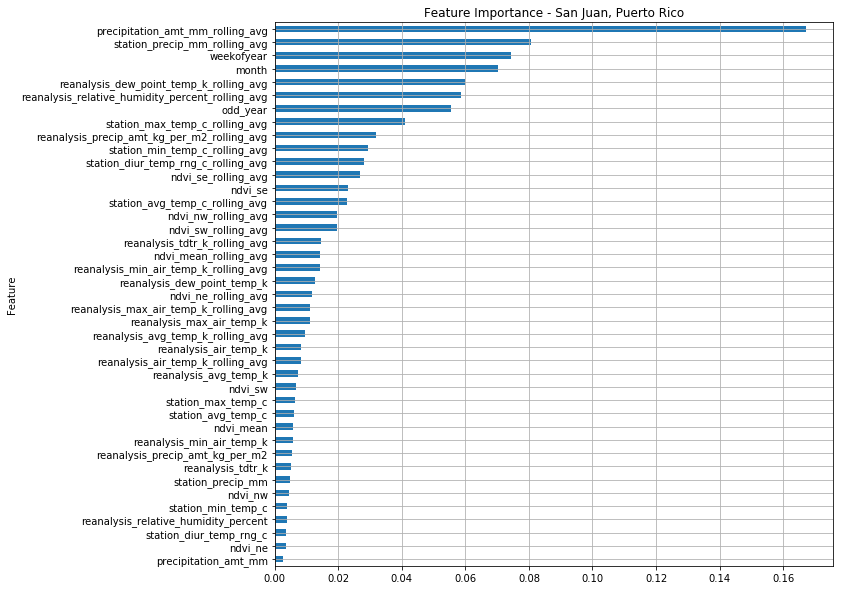

In [13]:
model = ExtraTreesRegressor()
feature_imp = pd.DataFrame({'Feature' : [], 'Importance' : []})
for i in range(1,10):
    train_features_sj, test_features_sj, train_outcomes_sj, test_outcomes_sj = train_test_split(
        data_sj_n,
        data_sj['total_cases'],
        test_size = 0.3
    )
    for i in range(1,10):
        model.fit(train_features_sj, train_outcomes_sj)
        imp = pd.DataFrame({'Feature': data_sj_n.columns, 'Importance':model.feature_importances_})
        frames = [feature_imp, imp]
        feature_imp = pd.concat(frames).reset_index(drop = True)
feature_imp = feature_imp.groupby(['Feature'])['Importance'].mean().to_frame(name = 'Importance').reset_index()
feature_imp = feature_imp.set_index('Feature')
feature_imp.sort_values(by='Importance').plot(kind='barh', title='Feature Importance - San Juan, Puerto Rico', grid = True, legend = False, figsize=(10,10))

## Update Train/Test Data

In [146]:
# San Juan
# ['month','reanalysis_relative_humidity_percent', 'reanalysis_dew_point_temp_k', 'station_avg_temp_c', 'reanalysis_tdtr_k']
train_features_sj, test_features_sj, train_outcomes_sj, test_outcomes_sj = train_test_split(
    data_sj_n[['month',
               'odd_year',
               'ndvi_sw_rolling_avg',
               'precipitation_amt_mm_rolling_avg',
               'reanalysis_dew_point_temp_k_rolling_avg',
               'reanalysis_precip_amt_kg_per_m2_rolling_avg',
               'reanalysis_relative_humidity_percent_rolling_avg',
               'station_diur_temp_rng_c_rolling_avg',
               'station_max_temp_c_rolling_avg']],
    data_sj['total_cases'],
    test_size = 0.3
)

## Grid Search Cross Validation

In [158]:
params = {'n_neighbors':range(2, 10), 'weights':['uniform', 'distance']}
folds = KFold(n_splits = 10, shuffle=True)
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid=params, cv=folds, scoring='neg_mean_absolute_error')
knr_preds_sj = grid_search.fit(train_features_sj, train_outcomes_sj).predict(test_features_sj)
print(mean_absolute_error(test_outcomes_sj, knr_preds_sj))

7.115495327107209


In [130]:
grid_search.cv_results_['params'][grid_search.best_index_]

{'n_neighbors': 3, 'weights': 'distance'}

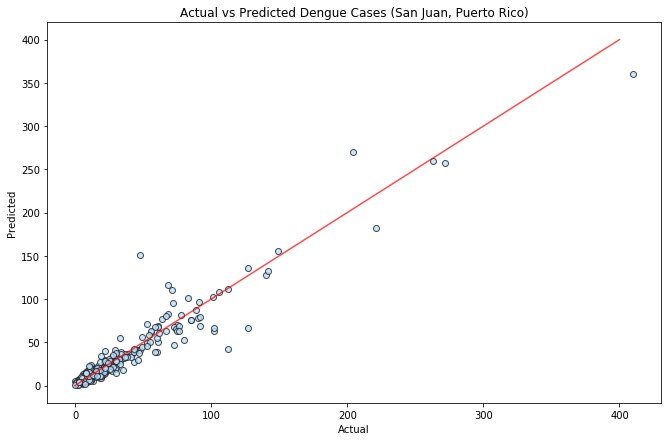

In [160]:
plt.subplots(figsize=(11,7))
plt.title('Actual vs Predicted Dengue Cases (San Juan, Puerto Rico)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.scatter(test_outcomes_sj, knr_preds_sj, edgecolors = '#1e1e1e', color='#bae1ff', alpha=0.8)
plt.plot([0, 400], [0, 400], 'red', alpha=0.7)

In [161]:
knr_preds_final_sj = knr_reg.fit(train_features_sj, train_outcomes_sj).predict(
    data_test_sj_n[['month',
                    'odd_year',
                    'ndvi_sw_rolling_avg',
                    'precipitation_amt_mm_rolling_avg',
                    'reanalysis_dew_point_temp_k_rolling_avg',
                    'reanalysis_precip_amt_kg_per_m2_rolling_avg',
                    'reanalysis_relative_humidity_percent_rolling_avg',
                    'station_diur_temp_rng_c_rolling_avg',
                    'station_max_temp_c_rolling_avg']]
)

In [162]:
submission_sj = data_test_sj[['city', 'year', 'weekofyear']].copy()
submission_sj['total_cases'] = np.round(knr_preds_final_sj).astype(int)

# Iquitos

## Train/Test split

In [116]:
train_features_iq, test_features_iq, train_outcomes_iq, test_outcomes_iq = train_test_split(
    data_iq_n,
    data_iq['total_cases'],
    test_size = 0.3
)

## Features Selection

In [117]:
from sklearn.feature_selection import RFE

for n in range(1,20,1):
    
    train_features_iq, test_features_iq, train_outcomes_iq, test_outcomes_iq = train_test_split(
        data_iq_n,
        data_iq['total_cases'],
        test_size = 0.3
    )

    rfe = RFE(ExtraTreesRegressor(), n)
    fit = rfe.fit(test_features_iq, test_outcomes_iq)

    train_features_iq, test_features_iq, train_outcomes_iq, test_outcomes_iq = train_test_split(
        data_iq[data_iq_n.columns[fit.ranking_ == 1]],
        data_iq['total_cases'],
        test_size = 0.3
    )

    knr_reg = KNeighborsRegressor(n_neighbors = 5, weights = 'distance')
    knr_preds_iq = knr_reg.fit(train_features_iq, train_outcomes_iq).predict(test_features_iq)
    print('Features:', n, ', MAE:', mean_absolute_error(test_outcomes_iq, knr_preds_iq))

Features: 1 , MAE: 8.209609228239756
Features: 2 , MAE: 4.697448367086086
Features: 3 , MAE: 5.226981254883604
Features: 4 , MAE: 6.994960818987014
Features: 5 , MAE: 6.370167933874127
Features: 6 , MAE: 8.043565727051021
Features: 7 , MAE: 6.969268018848605
Features: 8 , MAE: 7.067055307835698
Features: 9 , MAE: 5.107454676317425
Features: 10 , MAE: 4.893316348587543
Features: 11 , MAE: 4.551004838857985
Features: 12 , MAE: 5.591728842047844
Features: 13 , MAE: 7.211431746129149
Features: 14 , MAE: 5.728514833976328
Features: 15 , MAE: 5.852502977273932
Features: 16 , MAE: 6.396885916892225
Features: 17 , MAE: 7.054610003014748
Features: 18 , MAE: 6.762155651592077
Features: 19 , MAE: 3.8460276470194055


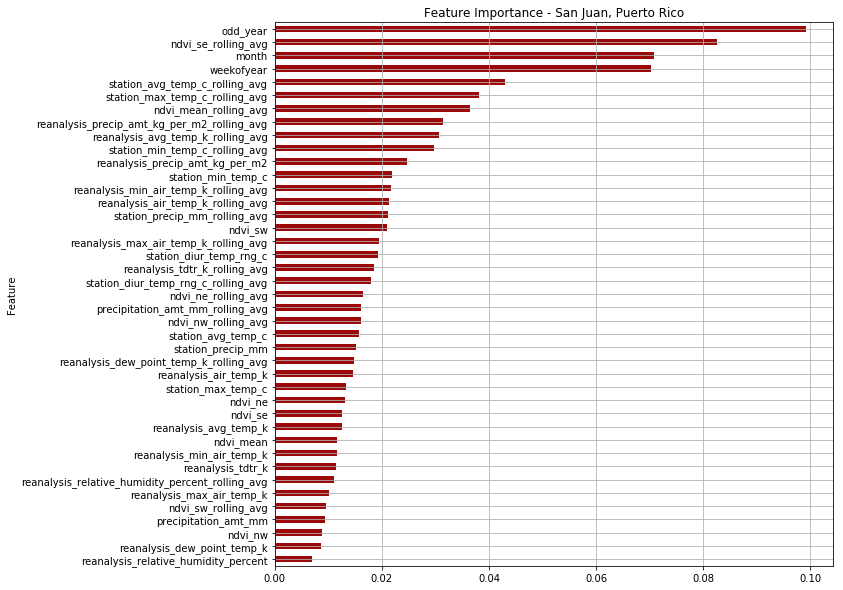

In [119]:
model = ExtraTreesRegressor()
feature_imp = pd.DataFrame({'Feature' : [], 'Importance' : []})
for i in range(1,10):
    train_features_iq, test_features_iq, train_outcomes_iq, test_outcomes_iq = train_test_split(
        data_iq_n,
        data_iq['total_cases'],
        test_size = 0.3
    )
    for i in range(1,10):
        model.fit(train_features_iq, train_outcomes_iq)
        imp = pd.DataFrame({'Feature': data_iq_n.columns, 'Importance':model.feature_importances_})
        frames = [feature_imp, imp]
        feature_imp = pd.concat(frames).reset_index(drop = True)
feature_imp = feature_imp.groupby(['Feature'])['Importance'].mean().to_frame(name = 'Importance').reset_index()
feature_imp = feature_imp.set_index('Feature')
feature_imp.sort_values(by='Importance').plot(kind='barh', title='Feature Importance - San Juan, Puerto Rico', grid = True, legend = False, color = '#9b0a0a', figsize=(10,10))

# Update Training Data

In [120]:
train_features_iq, test_features_iq, train_outcomes_iq, test_outcomes_iq = train_test_split(
    data_iq_n[['reanalysis_avg_temp_k',
               'month',
               'odd_year',
               'ndvi_nw_rolling_avg',
               'ndvi_sw_rolling_avg',
               'reanalysis_max_air_temp_k_rolling_avg',
               'reanalysis_tdtr_k_rolling_avg',
               'station_diur_temp_rng_c_rolling_avg',
               'station_max_temp_c_rolling_avg']],
    data_iq['total_cases'],
    test_size = 0.3
)

# Grid Search

In [121]:
params = {'n_neighbors':range(2, 10), 'weights':['uniform', 'distance']}
folds = KFold(n_splits = 10, shuffle=True)
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid=params, cv=folds, scoring='neg_mean_absolute_error')
knr_preds_iq = grid_search.fit(train_features_iq, train_outcomes_iq).predict(test_features_iq)
print(mean_absolute_error(test_outcomes_iq, knr_preds_iq))

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
       error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': range(1, 10), 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

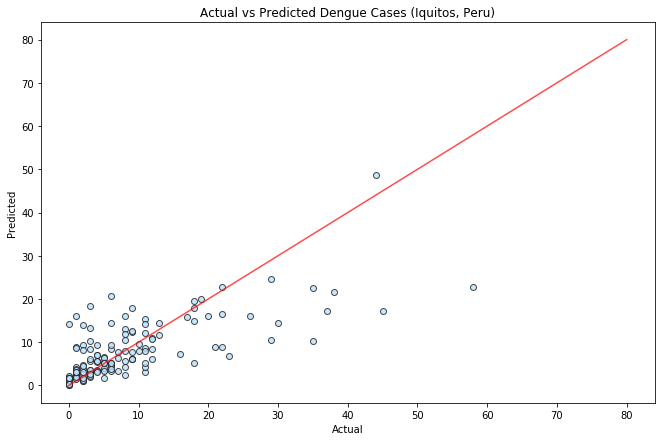

In [134]:
plt.subplots(figsize=(11,7))
plt.title('Actual vs Predicted Dengue Cases (Iquitos, Peru)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.scatter(test_outcomes_iq, knr_preds_iq, edgecolors = '#1e1e1e', color='#bae1ff', alpha=0.8)
plt.plot([0, 80], [0, 80], 'red', alpha=0.7)

In [135]:
knr_preds_final_iq = knr_reg.fit(train_features_iq, train_outcomes_iq).predict(
    data_test_iq_n[['reanalysis_avg_temp_k',
                    'month',
                    'odd_year',
                    'ndvi_nw_rolling_avg',
                    'ndvi_sw_rolling_avg',
                    'reanalysis_max_air_temp_k_rolling_avg',
                    'reanalysis_tdtr_k_rolling_avg',
                    'station_diur_temp_rng_c_rolling_avg',
                    'station_max_temp_c_rolling_avg']]
)

In [136]:
submission_iq = data_test_iq[['city', 'year', 'weekofyear']].copy()
submission_iq['total_cases'] = np.round(knr_preds_final_iq).astype(int)

# Submission

In [138]:
frames = [submission_sj, submission_iq]
submission = pd.concat(frames)
submission.to_csv('knn.csv', index = False)

# Xtreme Gradient Boosting

In [166]:
train_features_sj, test_features_sj, train_outcomes_sj, test_outcomes_sj = train_test_split(
    data_sj_n,
    data_sj['total_cases'],
    test_size = 0.3
)

# San Juan

In [169]:
from sklearn.feature_selection import RFE

for n in range(1,20,1):
    
    train_features_sj, test_features_sj, train_outcomes_sj, test_outcomes_sj = train_test_split(
        data_sj_n,
        data_sj['total_cases'],
        test_size = 0.3
    )

    rfe = RFE(XGBRegressor(), n)
    fit = rfe.fit(test_features_sj, test_outcomes_sj)

    train_features_sj, test_features_sj, train_outcomes_sj, test_outcomes_sj = train_test_split(
        data_sj[data_sj_n.columns[fit.ranking_ == 1]],
        data_sj['total_cases'],
        test_size = 0.3
    )

    xgb_reg = XGBRegressor(n_estimators = 1000, learning_rate = 0.03, max_depth = 10, subsample = 0.8, colsample_bytree = 0.701)
    xgb_preds_sj = xgb_reg.fit(train_features_sj, train_outcomes_sj).predict(test_features_sj)
    print('Features:', n, ', MAE:', mean_absolute_error(test_outcomes_sj, xgb_preds_sj))


Features: 1 , MAE: 30.403707799382676
Features: 2 , MAE: 26.29723465285803


KeyboardInterrupt: 

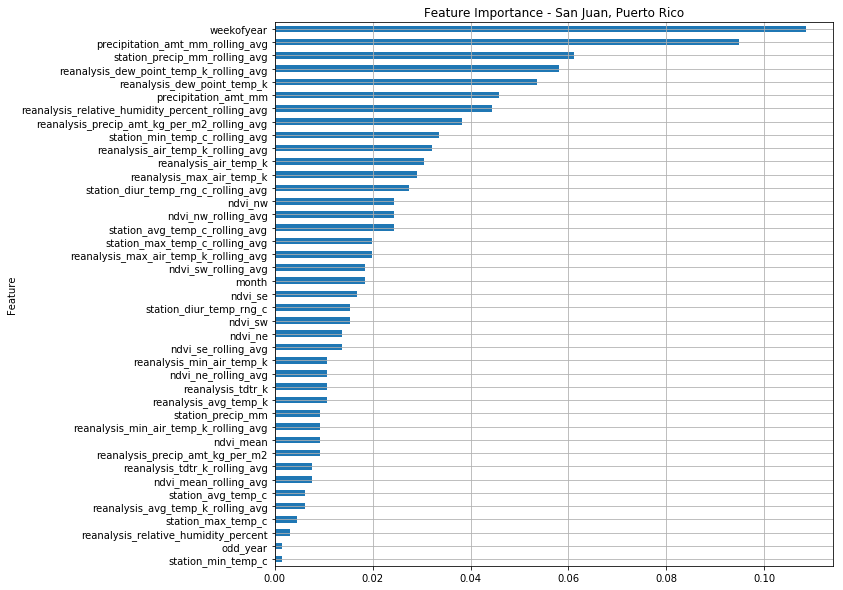

In [170]:
model = XGBRegressor()
feature_imp = pd.DataFrame()
for i in range(1,20):
    model.fit(train_features_sj, train_outcomes_sj)
    imp = pd.DataFrame({'Feature': data_sj_n.columns, 'Importance':model.feature_importances_})
    frames = [feature_imp, imp]
    feature_imp = pd.concat(frames).reset_index(drop = True)
feature_imp = feature_imp.groupby(['Feature'])['Importance'].mean().to_frame(name = 'Importance').reset_index()
feature_imp = feature_imp.set_index('Feature')
feature_imp.sort_values(by='Importance').plot(kind='barh', title='Feature Importance - San Juan, Puerto Rico', grid = True, legend = False, figsize=(10,10))

In [180]:
# San Juan
train_features_sj, test_features_sj, train_outcomes_sj, test_outcomes_sj = train_test_split(
    data_sj_n[['precipitation_amt_mm_rolling_avg',
               'weekofyear',
               'station_precip_mm_rolling_avg',
               'reanalysis_dew_point_temp_k_rolling_avg',
               'reanalysis_relative_humidity_percent_rolling_avg',
               'station_max_temp_c_rolling_avg',
               'reanalysis_air_temp_k_rolling_avg',
               'ndvi_mean_rolling_avg']],
    data_sj['total_cases'],
    test_size = 0.3
)

In [181]:
params = {'n_estimators':[1000], 'learning_rate':[0.03], 'max_depth':[10], 'subsample':[0.8], 'colsample_bytree':[0.701]}
folds = KFold(n_splits = 10, shuffle=True)
grid_search = GridSearchCV(XGBRegressor(), param_grid=params, cv=folds, scoring='neg_mean_absolute_error')
xgb_preds_sj = grid_search.fit(train_features_sj, train_outcomes_sj).predict(test_features_sj)
print(mean_absolute_error(test_outcomes_sj, xgb_preds_sj))

7.354653907897777


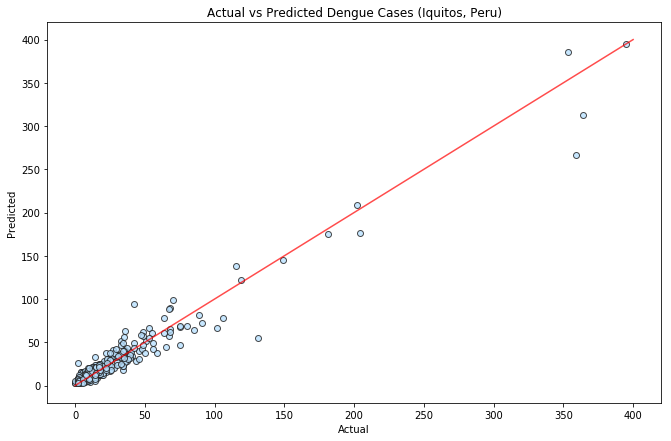

In [182]:
plt.subplots(figsize=(11,7))
plt.title('Actual vs Predicted Dengue Cases (Iquitos, Peru)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.scatter(test_outcomes_sj, xgb_preds_sj, edgecolors = '#1e1e1e', color='#bae1ff', alpha=0.8)
plt.plot([0, 400], [0, 400], 'red', alpha=0.7)

In [183]:
xgb_preds_final_sj = xgb_reg.fit(train_features_sj, train_outcomes_sj).predict(
    data_test_sj_n[['precipitation_amt_mm_rolling_avg',
               'weekofyear',
               'station_precip_mm_rolling_avg',
               'reanalysis_dew_point_temp_k_rolling_avg',
               'reanalysis_relative_humidity_percent_rolling_avg',
               'station_max_temp_c_rolling_avg',
               'reanalysis_air_temp_k_rolling_avg',
               'ndvi_mean_rolling_avg']]
)

In [184]:
submission_sj = data_test_sj[['city', 'year', 'weekofyear']].copy()
submission_sj['total_cases'] = np.round(xgb_preds_final_sj).astype(int)

# Iquitos

In [186]:
train_features_iq, test_features_iq, train_outcomes_iq, test_outcomes_iq = train_test_split(
    data_iq_n,
    data_iq['total_cases'],
    test_size = 0.3
)

In [ ]:
from sklearn.feature_selection import RFE

for n in range(1,20,1):
    
    train_features_iq, test_features_iq, train_outcomes_iq, test_outcomes_iq = train_test_split(
        data_iq_n,
        data_iq['total_cases'],
        test_size = 0.3
    )

    rfe = RFE(XGBRegressor(), n)
    fit = rfe.fit(test_features_iq, test_outcomes_iq)

    train_features_iq, test_features_iq, train_outcomes_iq, test_outcomes_iq = train_test_split(
        data_iq[data_iq_n.columns[fit.ranking_ == 1]],
        data_iq['total_cases'],
        test_size = 0.3
    )

    xgb_reg = XGBRegressor(n_estimators = 1000, learning_rate = 0.03, max_depth = 10, subsample = 0.8, colsample_bytree = 0.701)
    xgb_preds_iq = xgb_reg.fit(train_features_iq, train_outcomes_iq).predict(test_features_iq)
    print('Features:', n, ', MAE:', mean_absolute_error(test_outcomes_iq, xgb_preds_iq))


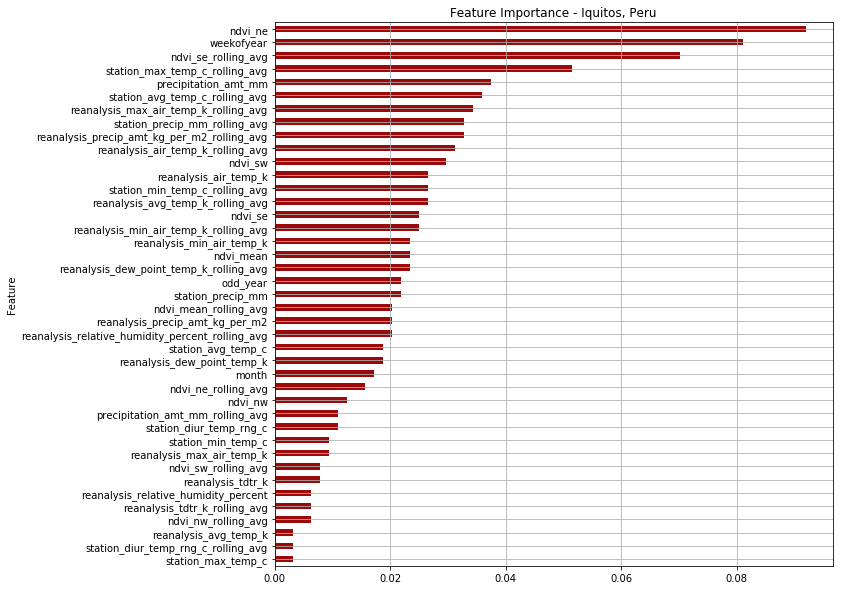

In [187]:
model = XGBRegressor()
feature_imp = pd.DataFrame()
for i in range(1,20):
    model.fit(train_features_iq, train_outcomes_iq)
    imp = pd.DataFrame({'Feature': data_iq_n.columns, 'Importance':model.feature_importances_})
    frames = [feature_imp, imp]
    feature_imp = pd.concat(frames).reset_index(drop = True)
feature_imp = feature_imp.groupby(['Feature'])['Importance'].mean().to_frame(name = 'Importance').reset_index()
feature_imp = feature_imp.set_index('Feature')
feature_imp.sort_values(by='Importance').plot(kind='barh', title='Feature Importance - Iquitos, Peru', grid = True, legend = False, color = '#9b0a0a', figsize=(10,10))

In [192]:
# ['month','odd_year','reanalysis_relative_humidity_percent', 'reanalysis_dew_point_temp_k', 'station_avg_temp_c', 'reanalysis_tdtr_k']
#Iquitos
train_features_iq, test_features_iq, train_outcomes_iq, test_outcomes_iq = train_test_split(
    data_iq_n[['ndvi_se_rolling_avg',
                'ndvi_ne_rolling_avg',
                'ndvi_nw_rolling_avg',
                'weekofyear',
                'station_max_temp_c_rolling_avg',
                'reanalysis_precip_amt_kg_per_m2_rolling_avg',
                'station_min_temp_c_rolling_avg']],
    data_iq['total_cases'],
    test_size = 0.3
)

In [193]:
params = {'n_estimators':[1000], 'learning_rate':[0.03], 'max_depth':[10], 'subsample':[0.8], 'colsample_bytree':[0.701]}
folds = KFold(n_splits = 10, shuffle=True)
grid_search = GridSearchCV(XGBRegressor(), param_grid=params, cv=folds, scoring='neg_mean_absolute_error')
xgb_preds_iq = grid_search.fit(train_features_iq, train_outcomes_iq).predict(test_features_iq)
print(mean_absolute_error(test_outcomes_iq, xgb_preds_iq))

3.3415694519983115


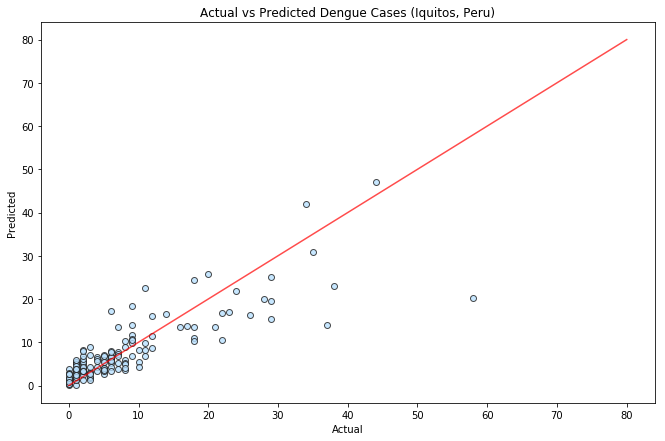

In [194]:
plt.subplots(figsize=(11,7))
plt.title('Actual vs Predicted Dengue Cases (Iquitos, Peru)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.scatter(test_outcomes_iq, xgb_preds_iq, edgecolors = '#1e1e1e', color='#bae1ff', alpha=0.8)
plt.plot([0, 80], [0, 80], 'red', alpha=0.7)

In [195]:
xgb_preds_final_iq = xgb_reg.fit(train_features_iq, train_outcomes_iq).predict(
    data_test_iq_n[['ndvi_se_rolling_avg',
                'ndvi_ne_rolling_avg',
                'ndvi_nw_rolling_avg',
                'weekofyear',
                'station_max_temp_c_rolling_avg',
                'reanalysis_precip_amt_kg_per_m2_rolling_avg',
                'station_min_temp_c_rolling_avg']]
)

In [196]:
submission_iq = data_test_iq[['city', 'year', 'weekofyear']].copy()
submission_iq['total_cases'] = np.round(xgb_preds_final_iq).astype(int)

In [197]:
frames = [submission_sj, submission_iq]
submission = pd.concat(frames)
submission.to_csv('xgb.csv', index = False)

# Random Forest Regression

In [217]:
train_features_sj, test_features_sj, train_outcomes_sj, test_outcomes_sj = train_test_split(
    data_sj_n,
    data_sj['total_cases'],
    test_size = 0.3
)

In [218]:
from sklearn.feature_selection import RFE

for n in range(1,20,1):
    
    train_features_sj, test_features_sj, train_outcomes_sj, test_outcomes_sj = train_test_split(
        data_sj_n,
        data_sj['total_cases'],
        test_size = 0.3
    )

    rfe = RFE(RandomForestRegressor(), n)
    fit = rfe.fit(test_features_sj, test_outcomes_sj)

    train_features_sj, test_features_sj, train_outcomes_sj, test_outcomes_sj = train_test_split(
        data_sj[data_sj_n.columns[fit.ranking_ == 1]],
        data_sj['total_cases'],
        test_size = 0.3
    )

    rf_reg = RandomForestRegressor()
    rf_preds_sj = rf_reg.fit(train_features_sj, train_outcomes_sj).predict(test_features_sj)
    print('Features:', n, ', MAE:', mean_absolute_error(test_outcomes_sj, rf_preds_sj))

Features: 1 , MAE: 27.156479591836735
Features: 2 , MAE: 18.891353383458647
Features: 3 , MAE: 17.303007518796996
Features: 4 , MAE: 12.927819548872181
Features: 5 , MAE: 10.946992481203006
Features: 6 , MAE: 9.80187969924812
Features: 7 , MAE: 10.791353383458647
Features: 8 , MAE: 9.487218045112781
Features: 9 , MAE: 9.703383458646618


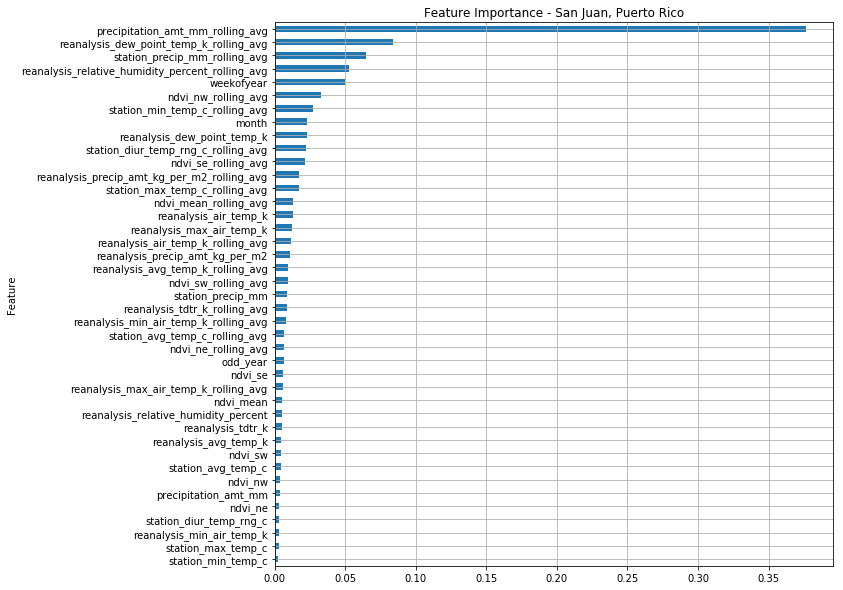

In [219]:
model = RandomForestRegressor()
feature_imp = pd.DataFrame({'Feature' : [], 'Importance' : []})
for i in range(1,10):
    train_features_sj, test_features_sj, train_outcomes_sj, test_outcomes_sj = train_test_split(
        data_sj_n,
        data_sj['total_cases'],
        test_size = 0.3
    )
    for i in range(1,10):
        model.fit(train_features_sj, train_outcomes_sj)
        imp = pd.DataFrame({'Feature': data_sj_n.columns, 'Importance':model.feature_importances_})
        frames = [feature_imp, imp]
        feature_imp = pd.concat(frames).reset_index(drop = True)
feature_imp = feature_imp.groupby(['Feature'])['Importance'].mean().to_frame(name = 'Importance').reset_index()
feature_imp = feature_imp.set_index('Feature')
feature_imp.sort_values(by='Importance').plot(kind='barh', title='Feature Importance - San Juan, Puerto Rico', grid = True, legend = False, figsize=(10,10))

In [220]:
train_features_sj, test_features_sj, train_outcomes_sj, test_outcomes_sj = train_test_split(
    data_sj_n[['precipitation_amt_mm_rolling_avg',
                'reanalysis_dew_point_temp_k_rolling_avg',
                'month',
                'ndvi_nw_rolling_avg',
                'reanalysis_relative_humidity_percent_rolling_avg',
                'ndvi_se_rolling_avg']],
    data_sj['total_cases'],
    test_size = 0.3
)

In [221]:
params = {'n_estimators':range(5, 30)}
folds = KFold(n_splits = 10, shuffle=True)
grid_search = GridSearchCV(RandomForestRegressor(), param_grid=params, cv=folds, scoring='neg_mean_absolute_error')
rf_preds_sj = grid_search.fit(train_features_sj, train_outcomes_sj).predict(test_features_sj)
print(mean_absolute_error(test_outcomes_sj, rf_preds_sj))

8.340803932909196


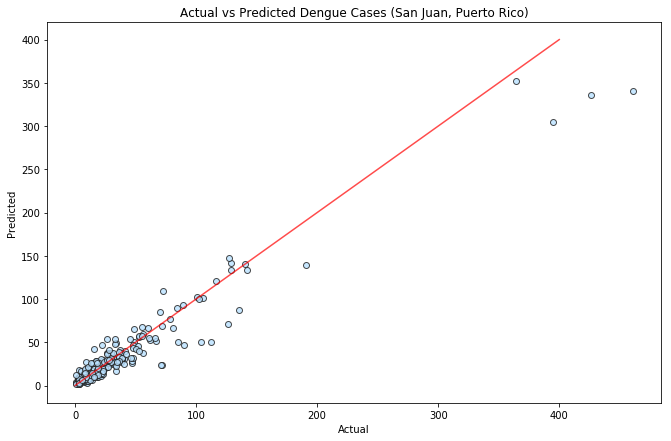

In [222]:
plt.subplots(figsize=(11,7))
plt.title('Actual vs Predicted Dengue Cases (San Juan, Puerto Rico)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.scatter(test_outcomes_sj, rf_preds_sj, edgecolors = '#1e1e1e', color='#bae1ff', alpha=0.8)
plt.plot([0, 400], [0, 400], 'red', alpha=0.7)

In [223]:
rf_preds_final_sj = rf_reg.fit(train_features_sj, train_outcomes_sj).predict(
    data_test_sj_n[['precipitation_amt_mm_rolling_avg',
                'reanalysis_dew_point_temp_k_rolling_avg',
                'month',
                'ndvi_nw_rolling_avg',
                'reanalysis_relative_humidity_percent_rolling_avg',
                'ndvi_se_rolling_avg']]
)

In [224]:
submission_sj = data_test_sj[['city', 'year', 'weekofyear']].copy()
submission_sj['total_cases'] = np.round(rf_preds_final_sj).astype(int)

In [225]:
train_features_iq, test_features_iq, train_outcomes_iq, test_outcomes_iq = train_test_split(
    data_iq_n,
    data_iq['total_cases'],
    test_size = 0.3
)

In [226]:
from sklearn.feature_selection import RFE

for n in range(1,20,1):
    
    train_features_iq, test_features_iq, train_outcomes_iq, test_outcomes_iq = train_test_split(
        data_iq_n,
        data_iq['total_cases'],
        test_size = 0.3
    )

    rfe = RFE(RandomForestRegressor(), n)
    fit = rfe.fit(test_features_iq, test_outcomes_iq)

    train_features_iq, test_features_iq, train_outcomes_iq, test_outcomes_iq = train_test_split(
        data_iq[data_iq_n.columns[fit.ranking_ == 1]],
        data_iq['total_cases'],
        test_size = 0.3
    )

    rf_reg = RandomForestRegressor()
    rf_preds_iq = rf_reg.fit(train_features_iq, train_outcomes_iq).predict(test_features_iq)
    print('Features:', n, ', MAE:', mean_absolute_error(test_outcomes_iq, rf_preds_iq))

Features: 1 , MAE: 6.88823877068558
Features: 2 , MAE: 6.736170212765957
Features: 3 , MAE: 6.273049645390071
Features: 4 , MAE: 4.990070921985815
Features: 5 , MAE: 4.948936170212765
Features: 6 , MAE: 4.792198581560284
Features: 7 , MAE: 4.388652482269503
Features: 8 , MAE: 5.356028368794327
Features: 9 , MAE: 4.175886524822695
Features: 10 , MAE: 4.8773049645390065
Features: 11 , MAE: 5.140425531914893
Features: 12 , MAE: 4.629078014184397
Features: 13 , MAE: 4.307092198581561
Features: 14 , MAE: 4.967375886524823
Features: 15 , MAE: 4.07304964539007
Features: 16 , MAE: 4.73758865248227
Features: 17 , MAE: 4.897163120567376
Features: 18 , MAE: 4.793617021276597
Features: 19 , MAE: 4.731914893617022


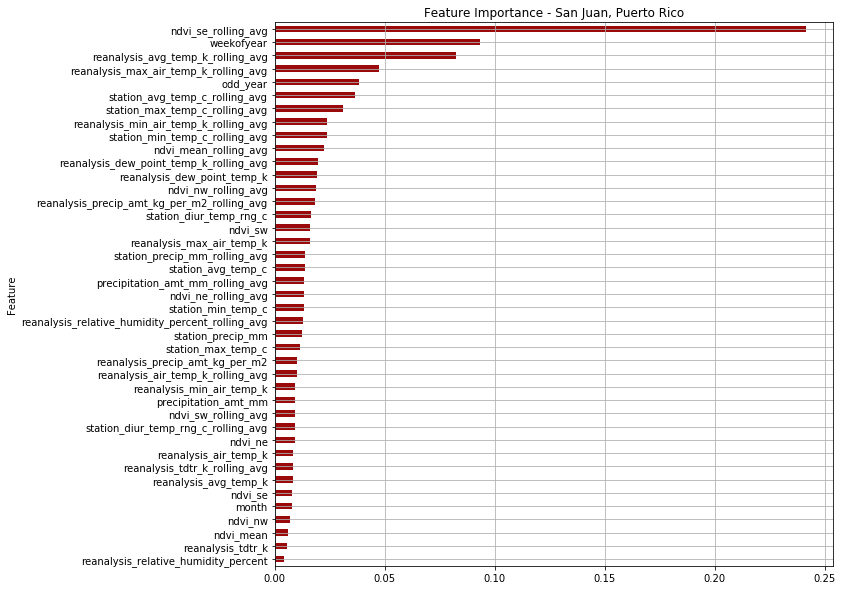

In [227]:
model = RandomForestRegressor()
feature_imp = pd.DataFrame({'Feature' : [], 'Importance' : []})
for i in range(1,10):
    train_features_iq, test_features_iq, train_outcomes_iq, test_outcomes_iq = train_test_split(
        data_iq_n,
        data_iq['total_cases'],
        test_size = 0.3
    )
    for i in range(1,10):
        model.fit(train_features_iq, train_outcomes_iq)
        imp = pd.DataFrame({'Feature': data_iq_n.columns, 'Importance':model.feature_importances_})
        frames = [feature_imp, imp]
        feature_imp = pd.concat(frames).reset_index(drop = True)
feature_imp = feature_imp.groupby(['Feature'])['Importance'].mean().to_frame(name = 'Importance').reset_index()
feature_imp = feature_imp.set_index('Feature')
feature_imp.sort_values(by='Importance').plot(kind='barh', title='Feature Importance - San Juan, Puerto Rico', grid = True, legend = False, color = '#9b0a0a', figsize=(10,10))

In [242]:
train_features_iq, test_features_iq, train_outcomes_iq, test_outcomes_iq = train_test_split(
    data_iq_n[['ndvi_se_rolling_avg',
                'reanalysis_avg_temp_k_rolling_avg',
                'weekofyear',
                'station_avg_temp_c_rolling_avg',
                'reanalysis_max_air_temp_k_rolling_avg',
                'odd_year',
                'station_max_temp_c_rolling_avg',
                'reanalysis_min_air_temp_k_rolling_avg']],
    data_iq['total_cases'],
    test_size = 0.3
)

In [243]:
params = {'n_estimators':range(5, 30)}
folds = KFold(n_splits = 10, shuffle=True)
grid_search = GridSearchCV(RandomForestRegressor(), param_grid=params, cv=folds, scoring='neg_mean_absolute_error')
rf_preds_iq = grid_search.fit(train_features_iq, train_outcomes_iq).predict(test_features_iq)
print(mean_absolute_error(test_outcomes_iq, rf_preds_iq))

3.816109422492402


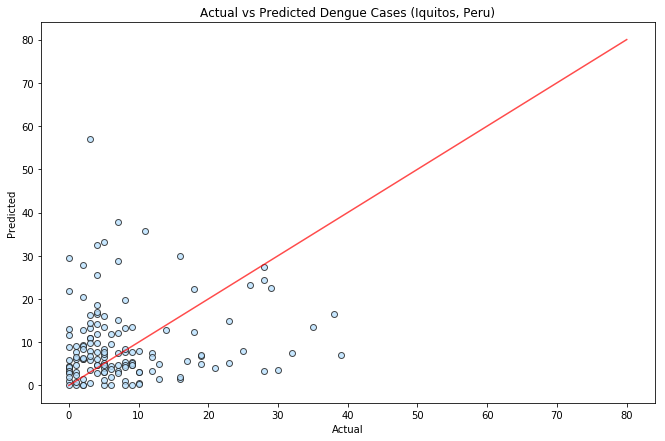

In [244]:
plt.subplots(figsize=(11,7))
plt.title('Actual vs Predicted Dengue Cases (Iquitos, Peru)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.scatter(test_outcome_iq, rf_preds_iq, edgecolors = '#1e1e1e', color='#bae1ff', alpha=0.8)
plt.plot([0, 80], [0, 80], 'red', alpha=0.7)

In [247]:
rf_preds_final_iq = rf_reg.fit(train_features_iq, train_outcomes_iq).predict(
    data_test_iq_n[['ndvi_se_rolling_avg',
                    'reanalysis_avg_temp_k_rolling_avg',
                    'weekofyear',
                    'station_avg_temp_c_rolling_avg',
                    'reanalysis_max_air_temp_k_rolling_avg',
                    'odd_year',
                    'station_max_temp_c_rolling_avg',
                    'reanalysis_min_air_temp_k_rolling_avg']]
)

In [248]:
submission_iq = data_test_iq[['city', 'year', 'weekofyear']].copy()
submission_iq['total_cases'] = np.round(rf_preds_final_iq).astype(int)

In [249]:
frames = [submission_sj, submission_iq]
submission = pd.concat(frames)
submission.to_csv('rf.csv', index = False)

# Bayesian Ridge Regression

In [250]:
train_features_sj, test_features_sj, train_outcomes_sj, test_outcomes_sj = train_test_split(
    data_sj_n,
    data_sj['total_cases'],
    test_size = 0.3
)

In [251]:
for n in range(1,20,1):
    
    train_features_sj, test_features_sj, train_outcome_sj, test_outcome_sj = train_test_split(
        data_sj_n,
        data_sj['total_cases'],
        test_size = 0.3
    )

    rfe = RFE(BayesianRidge(), n)
    fit = rfe.fit(test_features_sj, test_outcome_sj)

    train_features_sj, test_features_sj, train_outcome_sj, test_outcome_sj = train_test_split(
        data_sj[data_sj_n.columns[fit.ranking_ == 1]],
        data_sj['total_cases'],
        test_size = 0.3
    )

    br_preds_sj = br_reg.fit(train_features_sj, train_outcome_sj).predict(test_features_sj)
    print('Features:', n, ', MAE:', mean_absolute_error(test_outcomes_sj, br_preds_sj))


NameError: name 'br_reg' is not defined